In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator, Aer
from qiskit.visualization import plot_histogram

In [ ]:
c = "1"
d = "0"

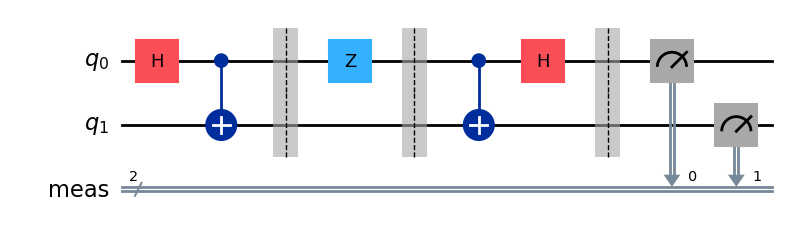

In [4]:
protocol  = QuantumCircuit(2)

#Prepating the ebit for superdense coding
protocol.h(0)
protocol.cx(0,1)
protocol.barrier()

#Alice's operations
if d=="1": 
    protocol.z(0)
if c=="1":
    protocol.x(0)
protocol.barrier()

#Bob's actions
protocol.cx(0,1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw("mpl"))

Measured 01 with frequency 1.0


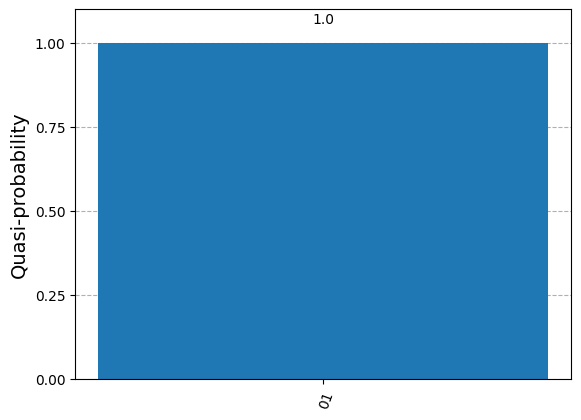

In [5]:
result = Sampler().run(protocol).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))

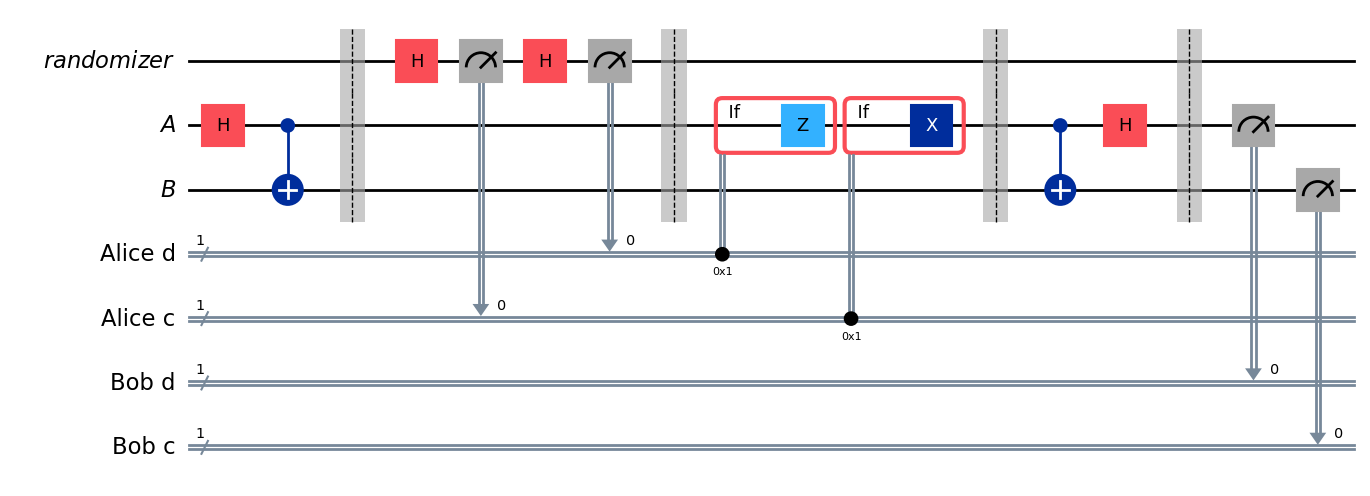

In [6]:
rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'randomizer' qubit twice to generate Alice's bits c and d.
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw(output='mpl'))


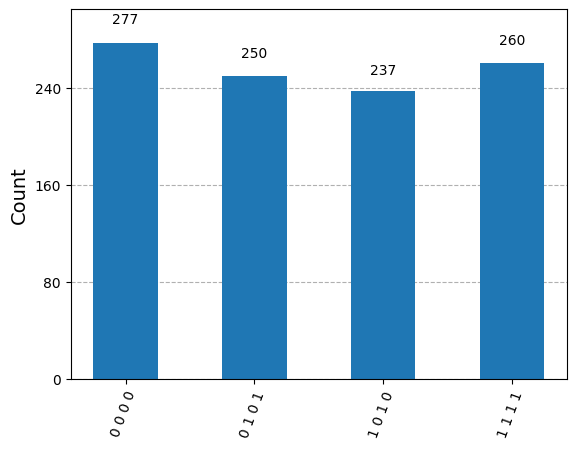

In [7]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

In [9]:
# Step 1: Initialize the entangled qubits for Alice and Bob
qc = QuantumCircuit(3, 2)  # qubit 0 and 1 are for Alice and Bob's entangled pair, qubit 2 is for random bit generation

# Create a Bell state between Alice (qubit 0) and Bob (qubit 1)
qc.h(0)  # Apply H gate to qubit 0
qc.cx(0, 1)  # Apply CNOT with qubit 0 as control and qubit 1 as target

In [10]:
# Step 2: Generate random bits for c and d using qubit 2
qc.h(2)  # Hadamard gate to create superposition
qc.measure(2, 0)  # Measure to get a random bit, store in classical bit 0
qc.reset(2)  # Reset qubit 2 for reuse

qc.h(2)
qc.measure(2, 1)  # Measure to get a second random bit, store in classical bit 1

In [12]:
# Step 3: Encoding the message based on the random values of c and d
simulator = Aer.get_backend('qasm_simulator')
job = simulator.run(qc,shots=1)
result = job.result()
random_bits = result.get_counts(qc).most_frequent()  # Extracting the most frequent measurement outcome
c, d = int(random_bits[1]), int(random_bits[0])  # Bits are extracted in reverse order from classical register

# Applying gates based on c and d
if c == 0 and d == 0:
    pass  # No gate needed if c = 0, d = 0
elif c == 0 and d == 1:
    qc.x(0)  # Apply X gate if c = 0, d = 1
elif c == 1 and d == 0:
    qc.z(0)  # Apply Z gate if c = 1, d = 0
elif c == 1 and d == 1:
    qc.z(0)
    qc.x(0)  # Apply both Z and X gates if c = 1, d = 1

In [14]:
# Step 4: Alice sends her qubit (qubit 0) to Bob

Random bits chosen by Alice (c, d): (1, 1)
Measurement results (Bob's interpretation of c and d):


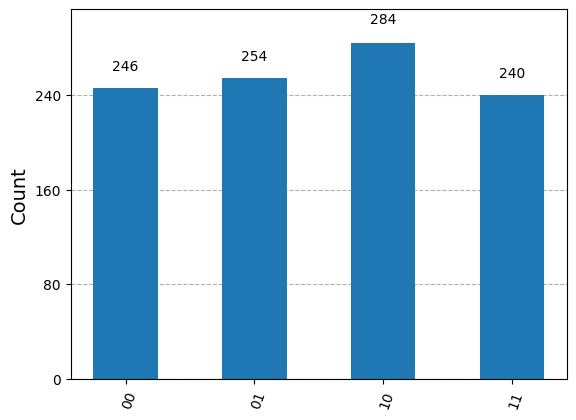

In [16]:
# Step 5: Bob decodes the message
qc.cx(0, 1)  # Apply CNOT to disentangle
qc.h(0)  # Apply H gate to decode

# Step 6: Measure to verify c and d
qc.measure([0, 1], [0, 1])  # Measure the qubits and store in classical bits

# Execute the circuit
result = simulator.run(qc, shots=1024).result()
counts = result.get_counts(qc)

# Show the results
print(f"Random bits chosen by Alice (c, d): ({c}, {d})")
print(f"Measurement results (Bob's interpretation of c and d):")
plot_histogram(counts)
